In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


[[1.00000000e+00 2.43116734e-01 1.43695961e-02 8.49325705e-04]
 [2.43116734e-01 1.00000000e+00 5.91057466e-02 3.49348928e-03]
 [1.43695961e-02 5.91057466e-02 1.00000000e+00 5.91057466e-02]
 [8.49325705e-04 3.49348928e-03 5.91057466e-02 1.00000000e+00]]


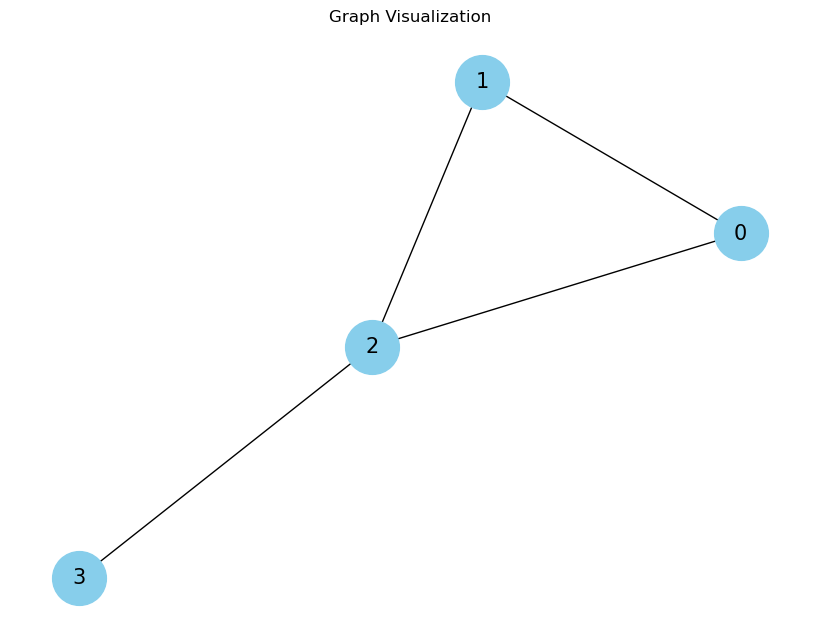

Output Features Xˆ:
[[1 2]
 [2 3]
 [4 5]
 [6 7]]
Edge Index Eˆ:
[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1), (2, 3), (3, 2)]


In [18]:
def preprocess_features(X):
    # Calculate pairwise distances between features
    n = X.shape[0]
    pairwise_distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                pairwise_distances[i, j] = np.linalg.norm(X[i] - X[j])
    return pairwise_distances

def calculate_similarity(pairwise_distances):
    # Calculate similarity scores
    similarity_scores = np.exp(-pairwise_distances)
    print(similarity_scores)
    return similarity_scores

def normalize_similarity(similarity_scores):
    # Normalize similarity scores
    min_score = np.min(similarity_scores)
    max_score = np.max(similarity_scores)
    normalized_scores = (similarity_scores - min_score) / (max_score - min_score)
    return normalized_scores

def edge_formation(similarity_scores, rl):
    # Form edges based on similarity threshold rl
    n = similarity_scores.shape[0]
    edge_index = []
    for i in range(n):
        for j in range(n):
            if i != j and similarity_scores[i, j] > rl:
                edge_index.append((i, j))
    return edge_index

def output_features(X, edge_index):
    # Output features corresponding to formed edges
    output_features = set()
    for edge in edge_index:
        output_features.add(edge[0])
    return np.array([X[i] for i in output_features])

# Input features X
X = np.array([[1, 2], [2, 3], [4, 5], [6, 7]])

# Lower limit of similarity score to determine edge formation rl
rl = 0.01

# Step 1: Calculate pairwise distances between features
pairwise_distances = preprocess_features(X)

# Step 2: Calculate similarity scores
similarity_scores = calculate_similarity(pairwise_distances)

# Step 3: Normalize similarity scores
normalized_scores = normalize_similarity(similarity_scores)

# Step 4: Form edges based on similarity threshold rl
edge_index = edge_formation(normalized_scores, rl)

# Step 5: Output features corresponding to formed edges
output_features = output_features(X, edge_index)

# Create a graph
G = nx.Graph()

# Add nodes
for i in range(X.shape[0]):
    G.add_node(i)

# Add edges
for edge in edge_index:
    G.add_edge(edge[0], edge[1])

# Visualize the graph
pos = nx.spring_layout(G)  # positions for all nodes

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='k', linewidths=1, font_size=15)
plt.title('Graph Visualization')
plt.show()

print("Output Features Xˆ:")
print(output_features)
print("Edge Index Eˆ:")
print(edge_index)

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_kernels, beta):
        super(GraphEncoder, self).__init__()
        self.num_layers = num_layers
        self.num_kernels = num_kernels
        self.beta = beta
        
        # Graph convolution layers
        self.gnn_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.gnn_layers.append(nn.ModuleList([
                nn.Linear(hidden_dim, hidden_dim),
                nn.Linear(hidden_dim, hidden_dim)
            ]))
        
    def forward(self, X, edge_index):
        for l in range(self.num_layers):
            h = X.clone()
            for k in range(self.num_kernels):
                h_hat = F.normalize(self.gnn_layers[l][k][0](h), p=2, dim=1)
                alpha = F.softmax(-self.beta * torch.norm(h_hat.unsqueeze(1) - h_hat.unsqueeze(0), dim=2), dim=1)
                h_next = F.relu(self.gnn_layers[l][k][1](h) + torch.matmul(edge_index, alpha) @ self.gnn_layers[l][k][0](h))
                h = h_next
            X = torch.mean(h, dim=1)
        return X

class GraphDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphDecoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, X):
        h = F.relu(self.linear1(X))
        return self.linear2(h)

class GraphAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_kernels, beta, edge_pooling_rate):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GraphEncoder(input_dim, hidden_dim, output_dim, num_layers, num_kernels, beta)
        self.decoder = GraphDecoder(output_dim, hidden_dim, input_dim)
        self.edge_pooling_rate = edge_pooling_rate
        
    def forward(self, X, edge_index):
        encoded = self.encoder(X, edge_index)
        decoded = self.decoder(encoded)
        return decoded

# Define the Build_Graph function
def build_graph(X):
    # Dummy implementation, replace with actual implementation
    return torch.tensor([[0, 1], [1, 2]])

# Define the Optimization function
def optimize_loss(optimizer, criterion, output_features, input_features):
    # Calculate loss and optimize
    loss = criterion(output_features, input_features)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# Hyperparameters
T = 10  # Number of iterations
B = 1   # Number of batches
L = 2   # Number of layers
K = 2   # Number of kernels
beta = 0.5  # Beta value for GNN
edge_pooling_rate = 0.1

# Dummy input features X
X = torch.tensor([[1, 2], [2, 3], [4, 5], [6, 7]], dtype=torch.float32)

# Initialize autoencoder model
autoencoder = GraphAutoencoder(input_dim=X.shape[1], hidden_dim=32, output_dim=32, num_layers=L, num_kernels=K, beta=beta, edge_pooling_rate=edge_pooling_rate)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
for t in range(T):
    for b in range(B):
        # Step 4: Build graph for batch b
        edge_index = build_graph(X)

        # Step 5: Encoder
        output_features = autoencoder(X, edge_index)

        # Step 17: Calculate loss and optimize
        loss = optimize_loss(optimizer, criterion, output_features, X)

    print(f"Iteration {t+1}, Loss: {loss}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x2 and 32x32)